### EfficientNet B6 - max exposure

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
t = [None] * 10
for i in range(0,10):
  t[i] = pd.read_csv("test_set_"+str(i)+".csv")
  
print("Accuracy score pr fold")     
for i in range(0,10):
  print(accuracy_score(t[i].y_pred_test_rounded, t[i].y_true), end = ', ')
print("")

print("MSE pr fold")  
for i in range(0,10):
  print(mean_squared_error(t[i].y_pred_test, t[i].y_true), end = ', ')   
print("")
  
aggregate_pred = t[0].y_pred_test.values
for i in range(1,10):
  aggregate_pred += t[i].y_pred_test.values

aggregate_pred = aggregate_pred/10.0
print(str( accuracy_score(aggregate_pred.round().astype("int"), t[0].y_true) ) + " "+ 
      str( mean_squared_error(aggregate_pred, t[0].y_true) ) ) 

Accuracy score pr fold
0.7048543689320388, 0.6815533980582524, 0.6524271844660194, 0.7320388349514563, 0.6912621359223301, 0.6776699029126214, 0.6796116504854369, 0.6796116504854369, 0.7281553398058253, 0.6854368932038835, 
MSE pr fold
0.43451196999200425, 0.3060707878247112, 0.4362686803085344, 0.2702834854954916, 0.3897539491961922, 0.3209367247336584, 0.4114223695928597, 0.32056490401334686, 0.2941406328857888, 0.4479741380215303, 
0.7145631067961165 0.3047181875210732


### Boxplot of prediction pr age class

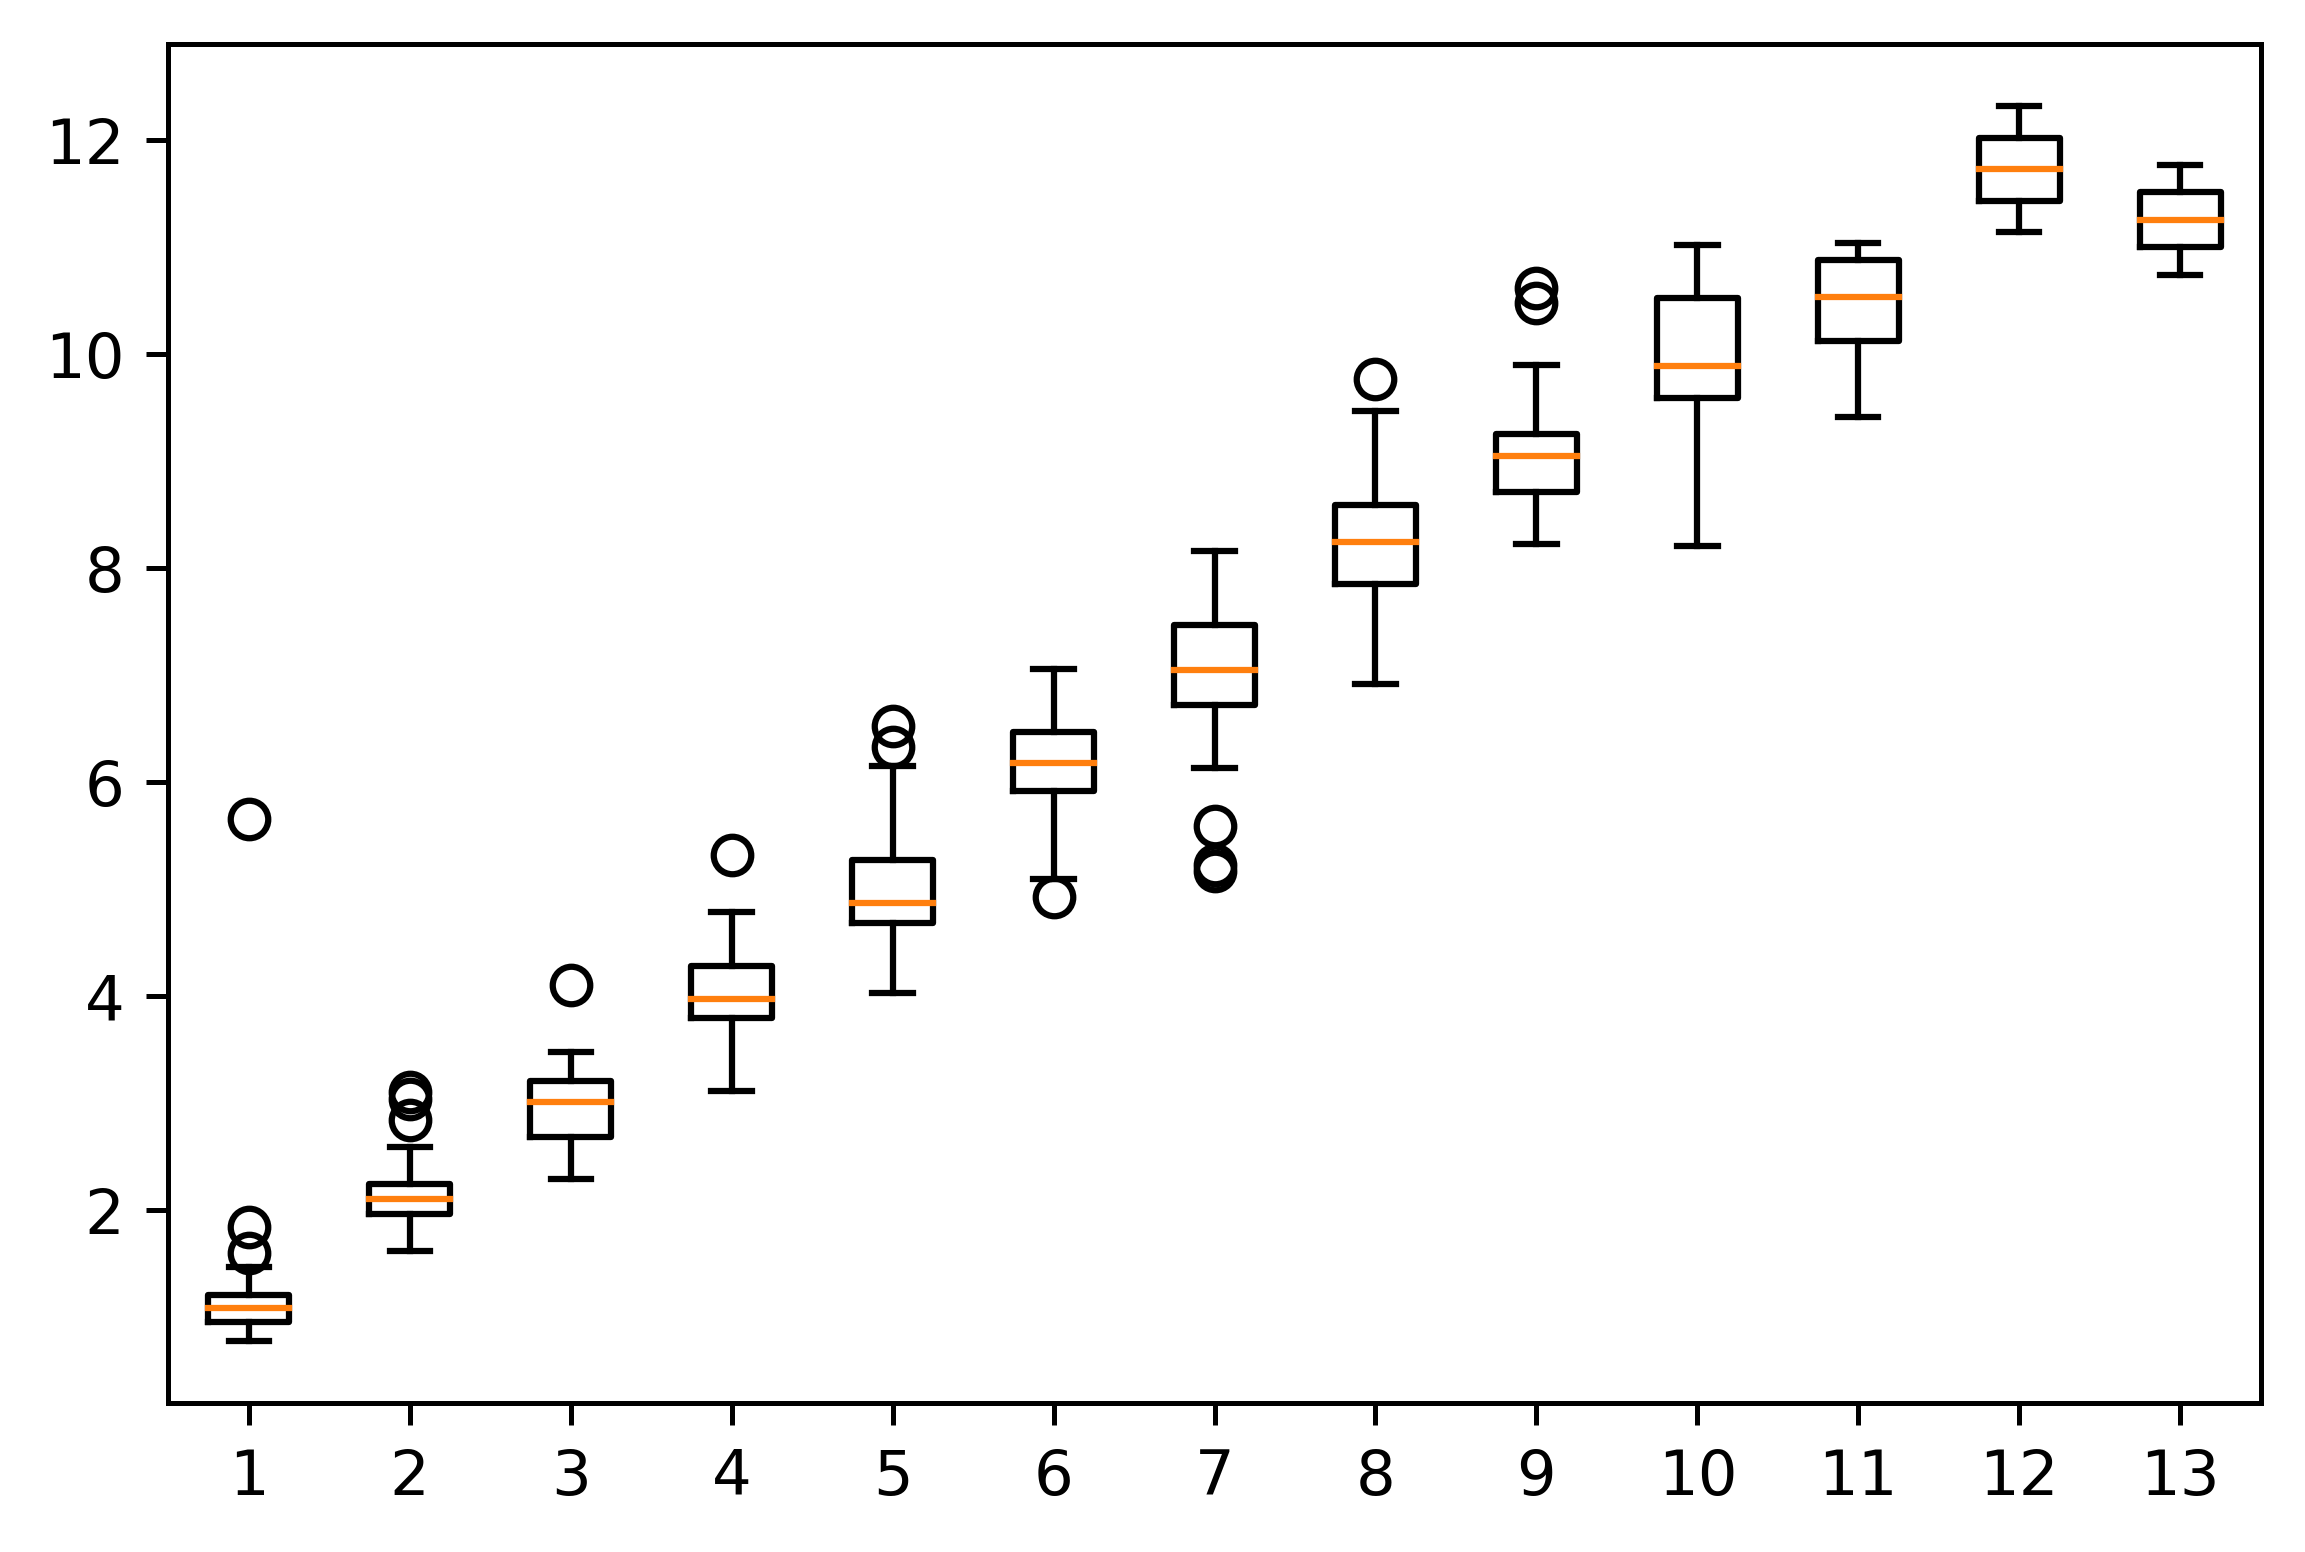

In [3]:
plt.rcParams['figure.dpi'] = 450
x = t[0].y_true
y = aggregate_pred
age_range = np.unique(x)
pr_age_group = []
for i in age_range:
    age_idx = np.where(x == i)
    pr_age_group.append( y[age_idx] )

plt.boxplot(pr_age_group)
plt.show()

### Residual plot per age group
The predictions show heteroskedasticity: heteroskedasticity happens when the standard deviations of a predicted variable, monitored over different values of an independent variable or as related to prior time periods, are non-constant.

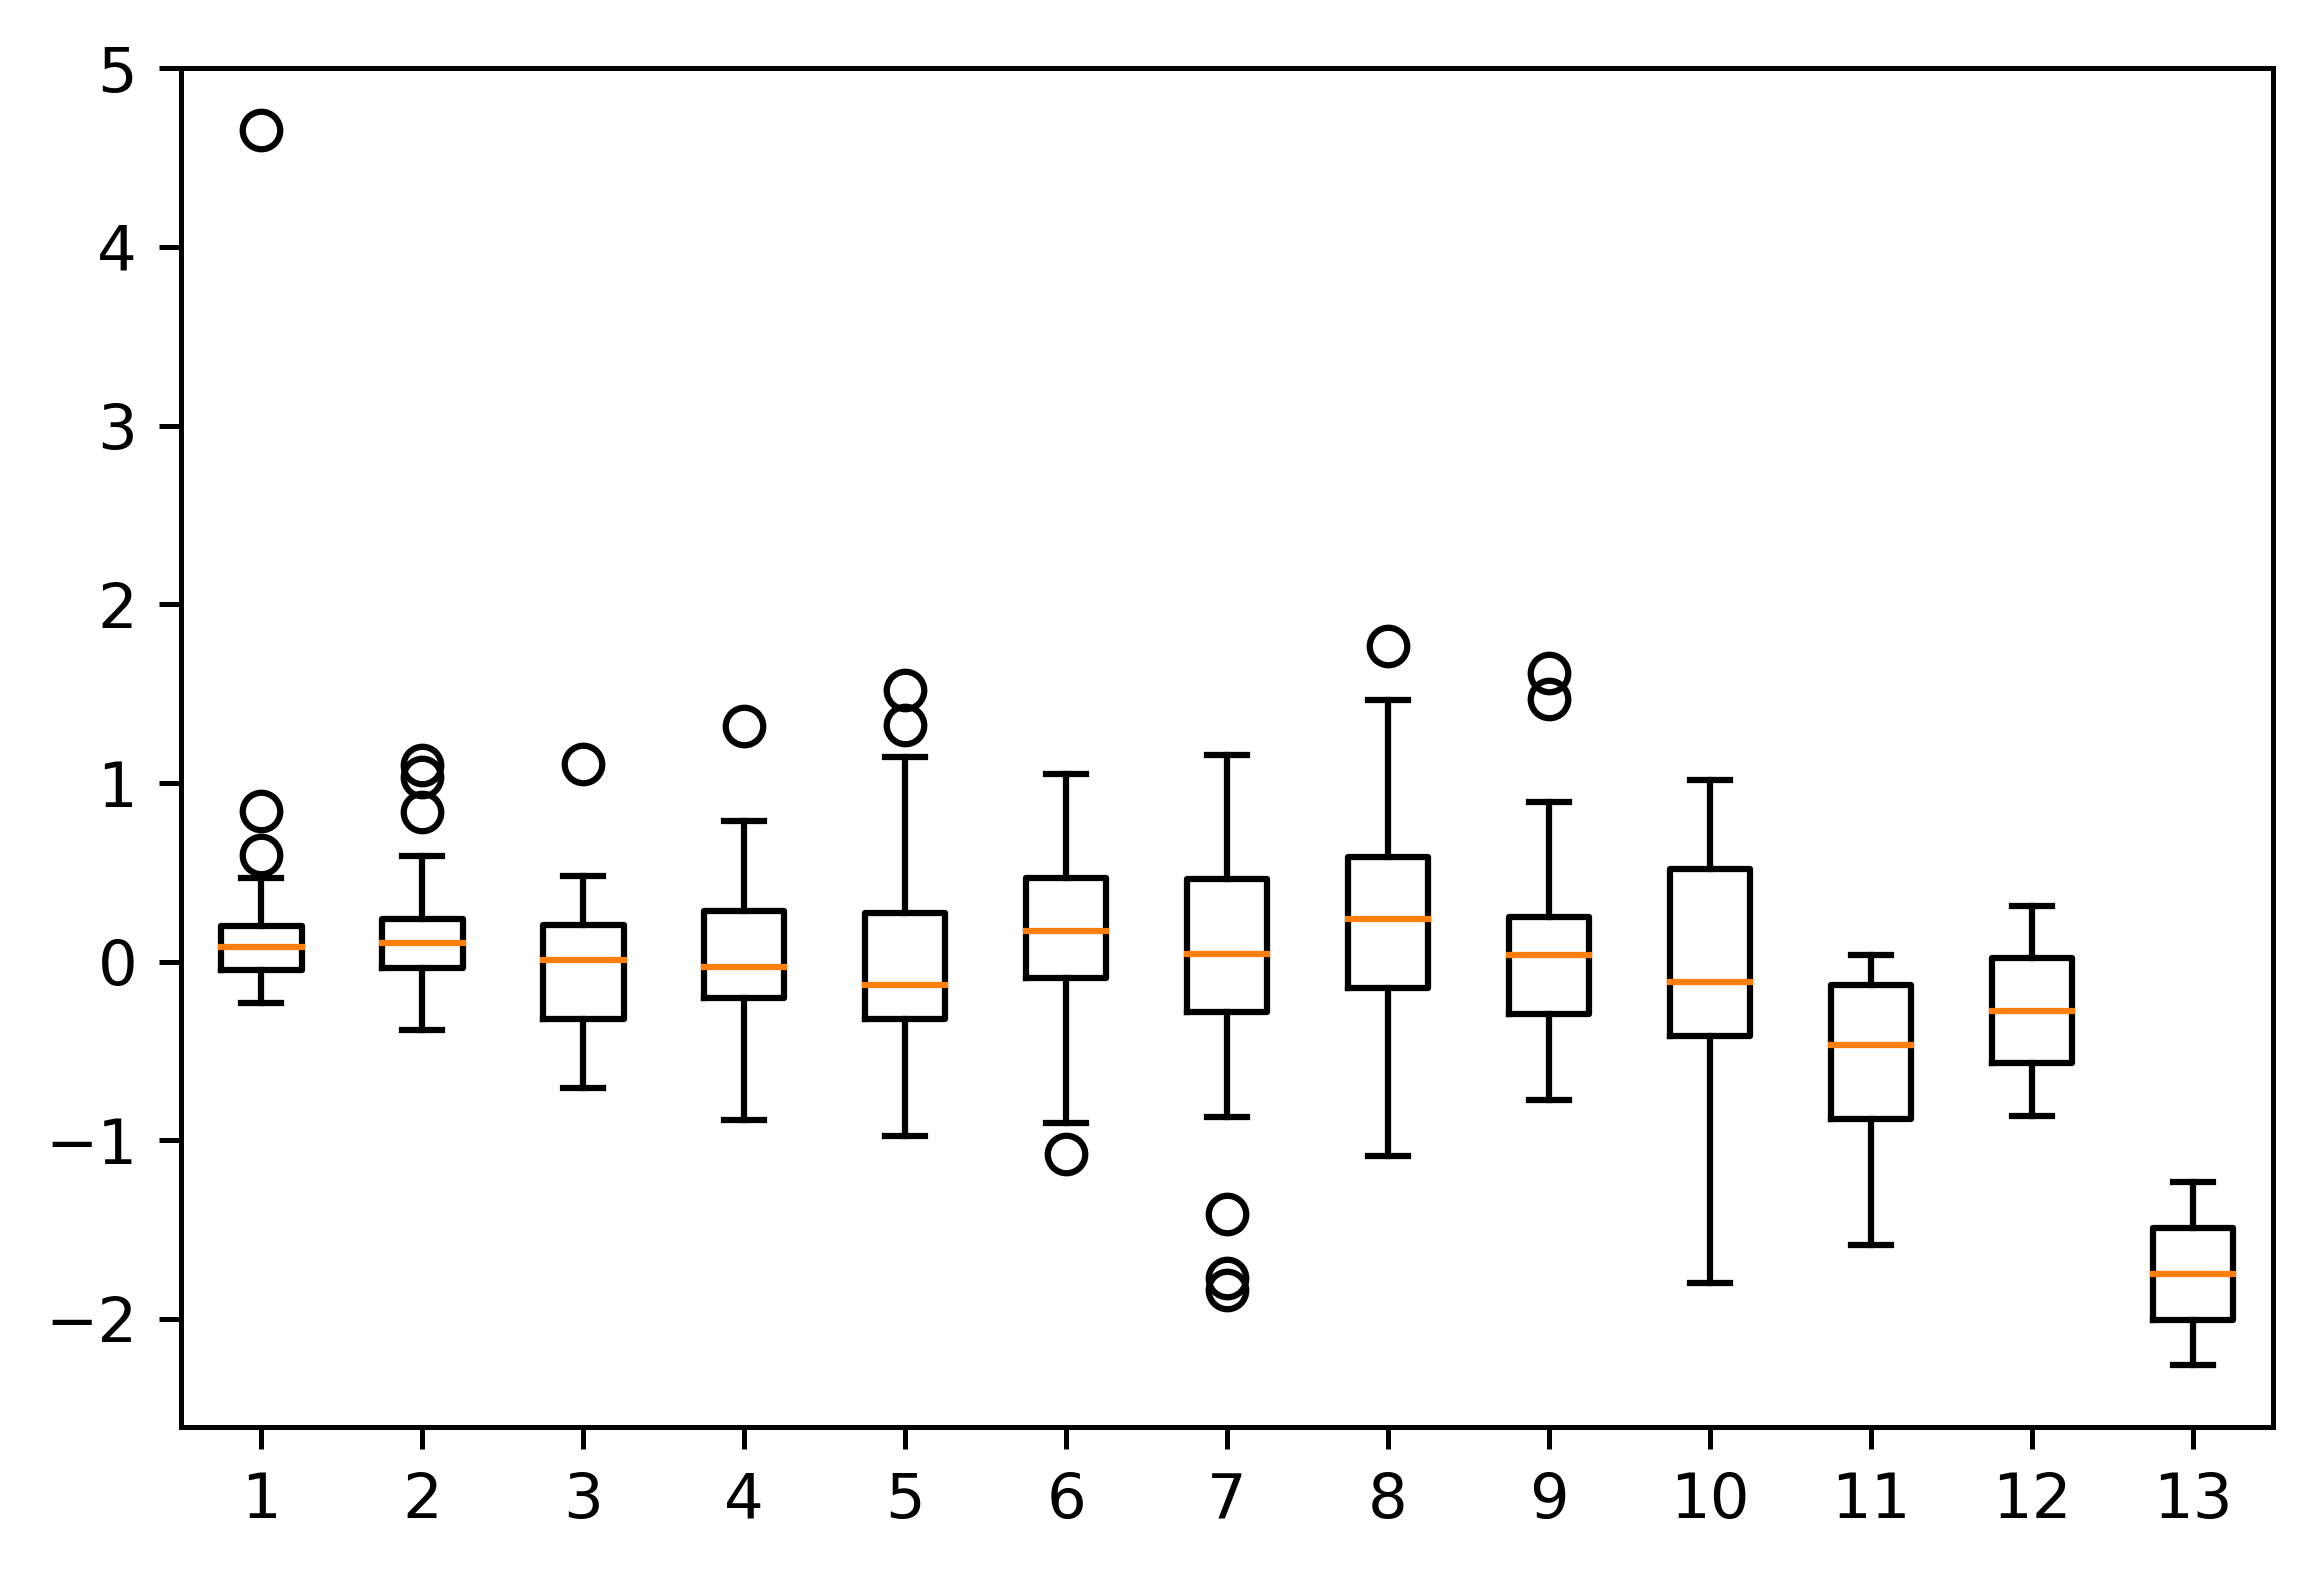

In [4]:
x = t[0].y_true
y = aggregate_pred
age_range = np.unique(x)
pr_age_group = []
for i in age_range:
    age_idx = np.where(x == i)
    pr_age_group.append( y[age_idx] - i )

plt.boxplot(pr_age_group)
plt.show()

### Box plot of mode error summarized over all age groups, and summary statistics

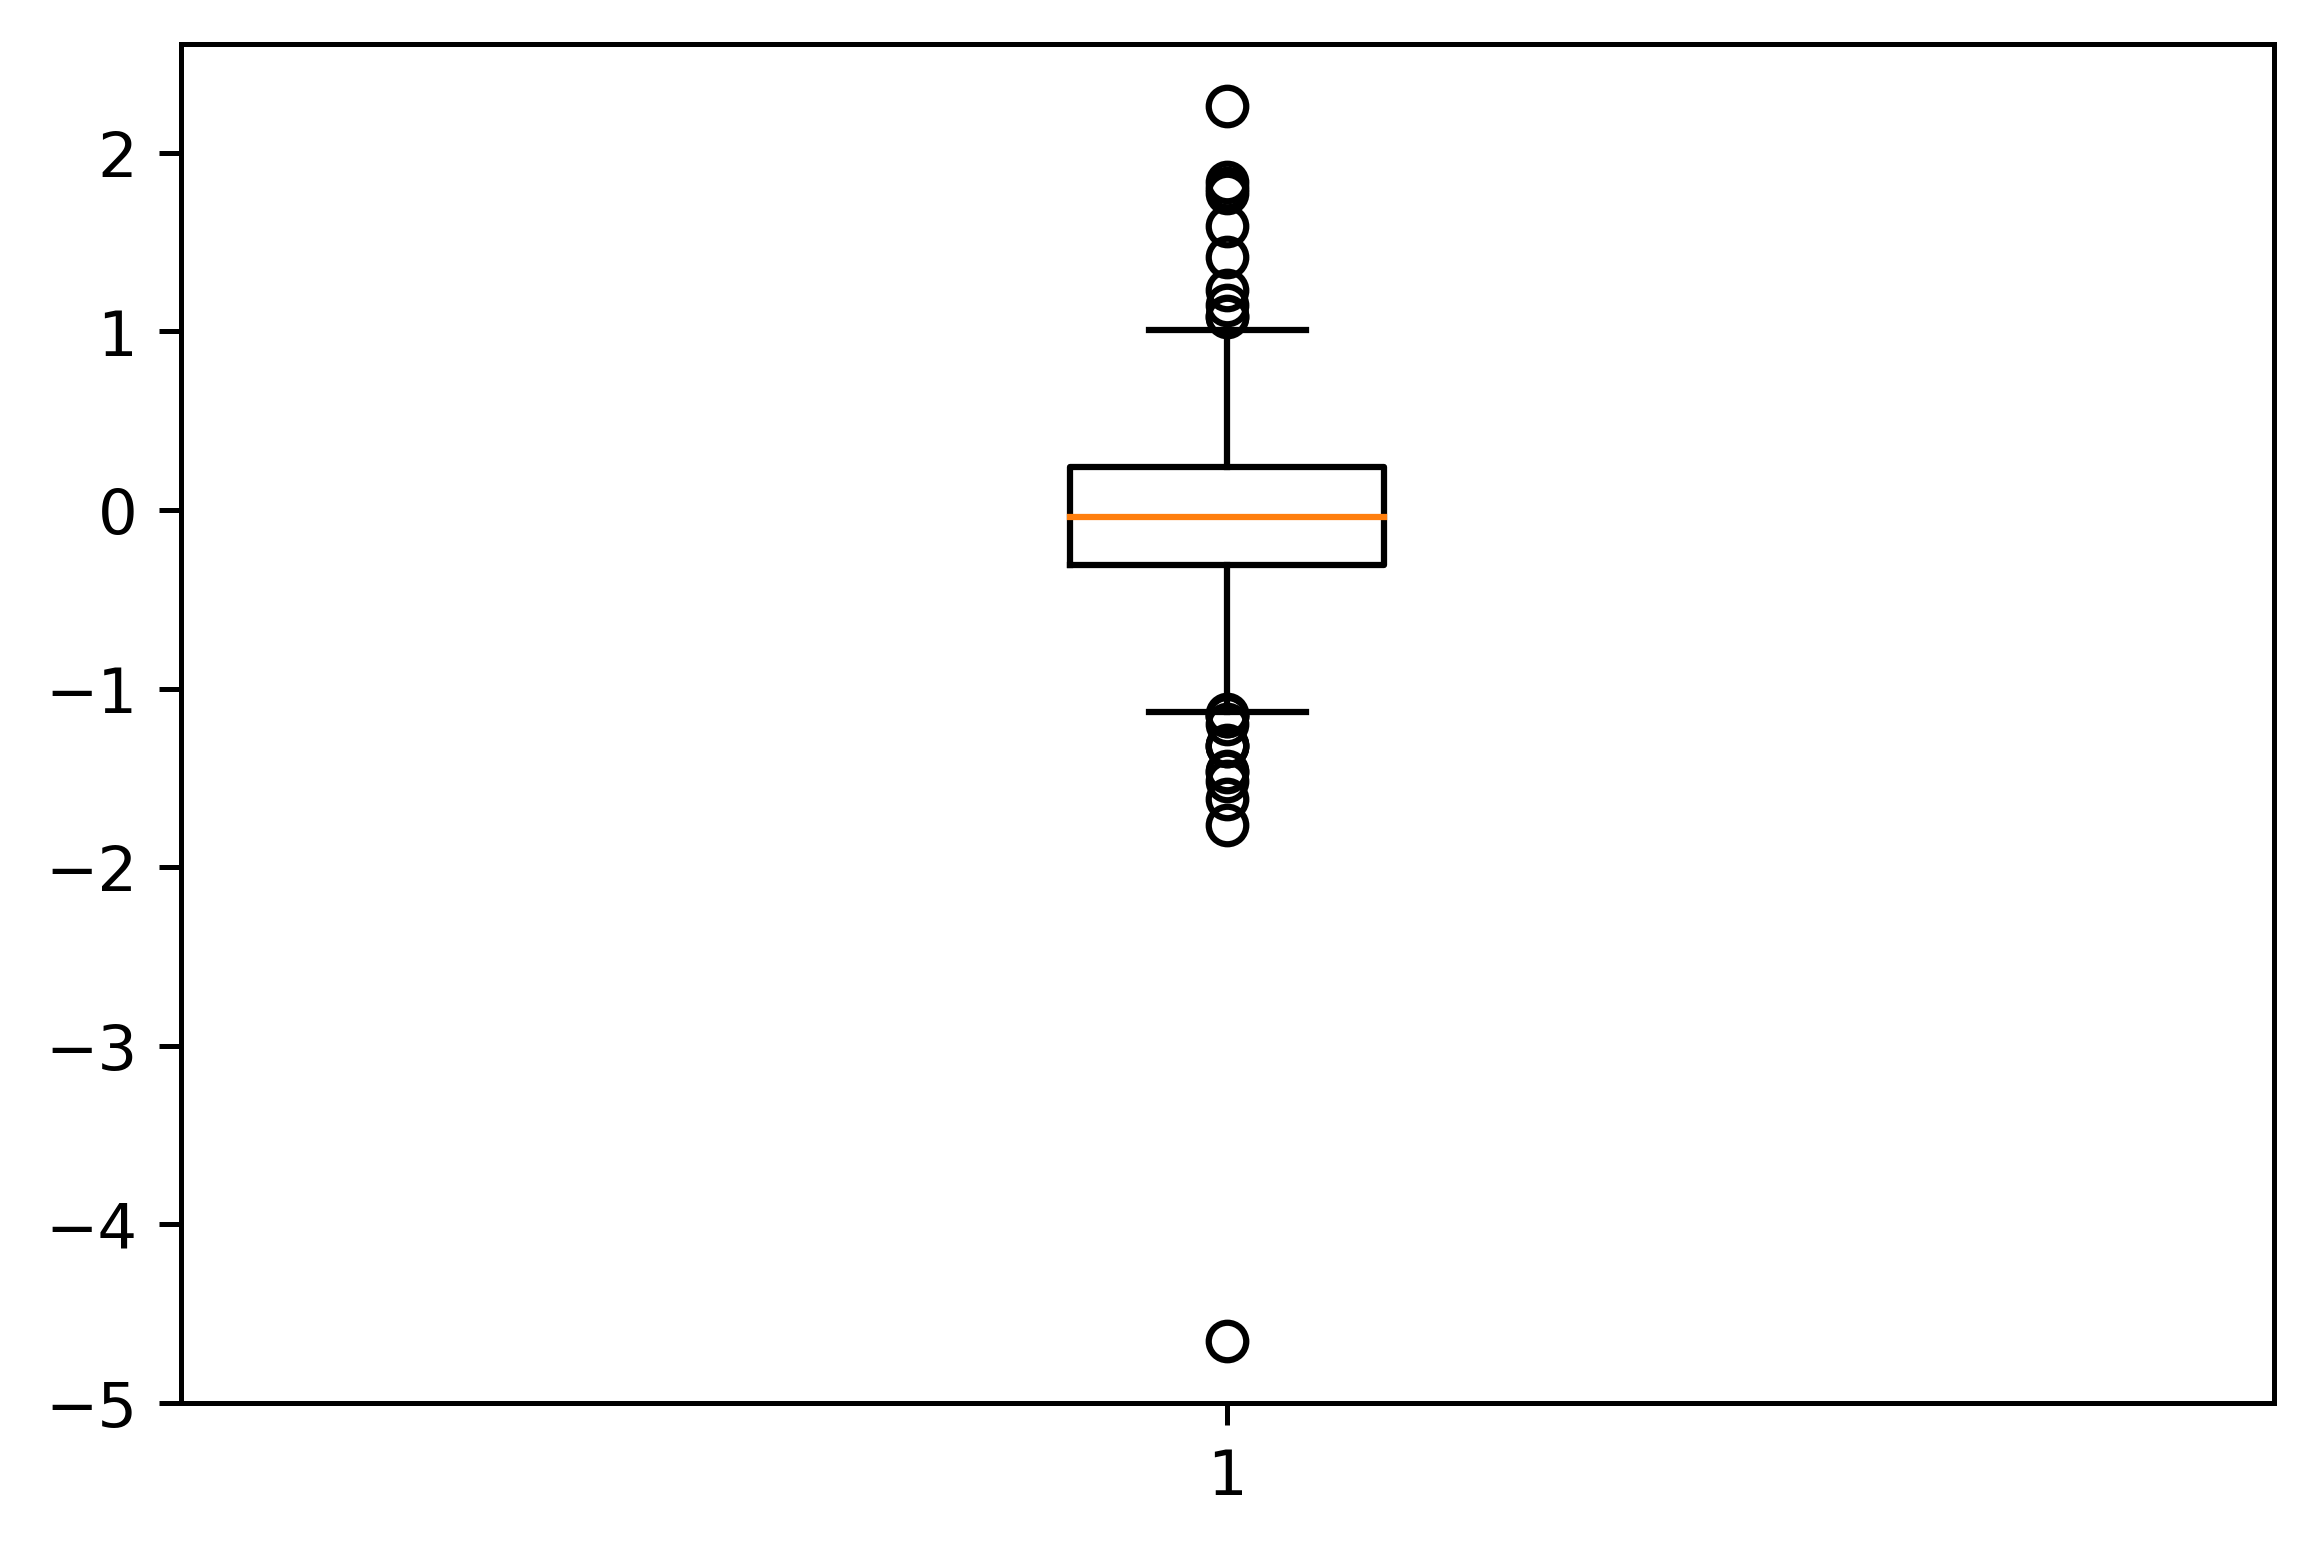

,y_true
count,515.000000
mean,-0.047309
std,0.550517
min,-4.655216
25%,-0.309743
50%,-0.042065
75%,0.241377
max,2.261165


In [5]:
x =  t[0].y_true
y = aggregate_pred
errors = x-y
pr_age_group = []
for i in age_range:
    age_idx = np.where(x == i)
    pr_age_group.append( y[age_idx] - i )

plt.boxplot(errors)
plt.show()


df_describe = pd.DataFrame(errors)
df_describe.describe()

### Scatterplot error predictions after rounding

errors in [0.5, 1.5):  138
errors in [1.5, \inf): 9
Total missclassification errors:147


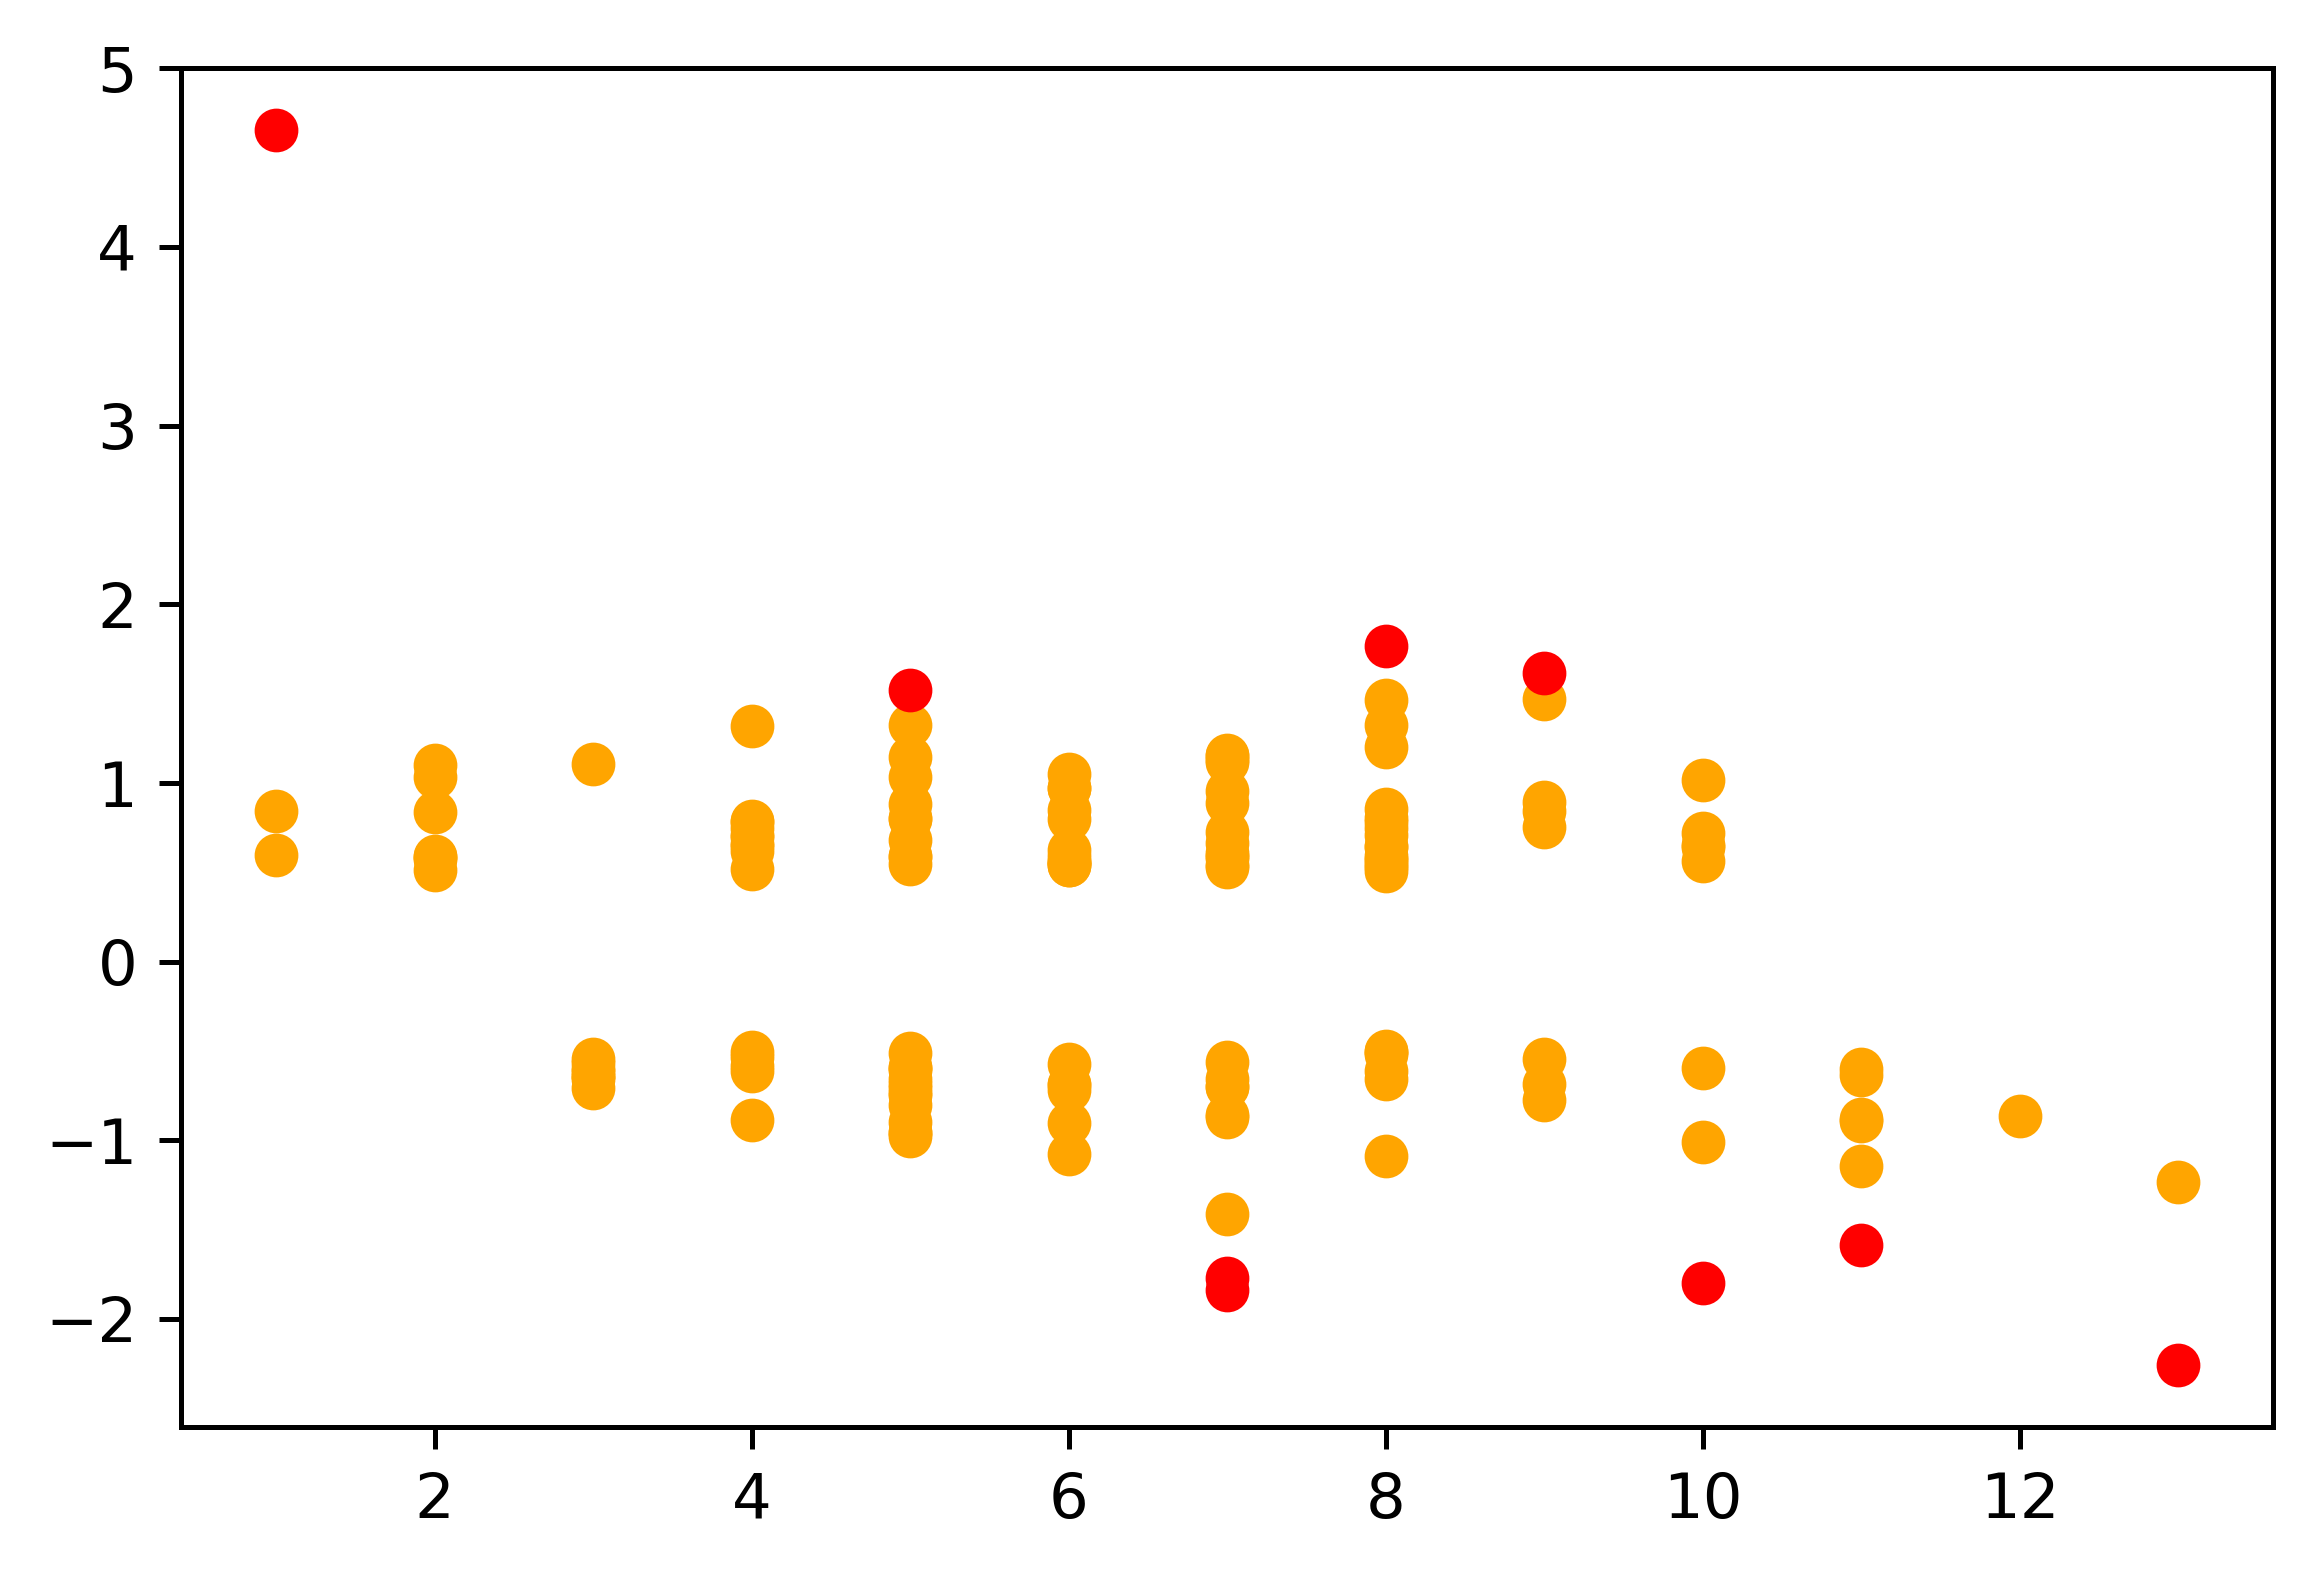

In [6]:
x =  t[0].y_true
y = aggregate_pred
age_range = np.unique(x)
pr_age_group = []
all_rounding_err1 = []
all_rounding_err2 = []
for i in age_range:
    age_idx = np.where(x == i)
    errors = y[age_idx] - i
    errors1 = errors[(np.abs(errors) >= 0.5) & (np.abs(errors) < 1.5)]
    x_axis = [i]*len(errors1)
    plt.scatter(x_axis, errors1, color="orange")
    
    errors2 = errors[np.abs(errors) >= 1.5 ]
    x_axis = [i]*len(errors2)
    plt.scatter(x_axis, errors2, color="red")
    all_rounding_err1.append(errors1)
    all_rounding_err2.append(errors2)
    

flat_list = [item for sublist in all_rounding_err1 for item in sublist]   
oneError = len(flat_list)
print("errors in [0.5, 1.5):  "+ str( oneError ) )

flat_list = [item for sublist in all_rounding_err2 for item in sublist]    
twoOrMore = len(flat_list)
print("errors in [1.5, \inf): "+ str( twoOrMore ) )
print("Total missclassification errors:"+str(oneError+twoOrMore))

plt.show()

### Excluding min/max prediction by fold pr prediction

In [7]:
all_preds = pd.DataFrame()
for i in range(1,10):
  all_preds[str(i)] = t[i].y_pred_test

all_preds.head()
all_preds['new_pred'] =0.0
for index, row in all_preds.iterrows():
    mask = np.logical_or(row == row.max(), row == row.min())
    #print(mask)
    #print(row)
    row_masked = np.ma.masked_array(row, mask = mask)
    #print(row_masked)
    all_preds['new_pred'].iloc[index] = row_masked.mean()
    
all_preds.head()

print("aggregate accuracy, mse")
print(str( accuracy_score(all_preds.new_pred.round().astype("int"), t[0].y_true) )+ " " + 
      str( mean_squared_error(all_preds.new_pred, t[0].y_true) ))

#0.7281553398058253 0.27677442836796534

aggregate accuracy, mse
0.7223300970873786 0.286823953192311


### Outliers >= 1.5 years

In [8]:
#x = y_true.age.values
#y = aggregate_pred.values
#age_range = np.unique(y_true.age.values)
test_set_files = pd.read_csv('test_set_files.csv')
x =  t[0].y_true
y = aggregate_pred
age_range = np.unique(x)
for i in age_range:
    age_idx = np.where(x == i)
    for j in age_idx[0]:
        if np.abs( y[ j ] - i ) >= 1.5:
            print(str(y[j])+" "+str(i), end=',')
            print(j)
            #print(test_set_files.iloc[j].path)

5.6552159786224365 1,308
6.51786060333252 5,462
5.226659202575684 7,71
5.164033365249634 7,362
9.764022254943848 8,13
10.617734336853028 9,393
8.198924160003662 10,369
9.412548732757568 11,502
10.738834857940674 13,342
